In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 957, done.
remote: Counting objects: 100% (387/387), done.
remote: Compressing objects: 100% (222/222), done.
remote: Total 957 (delta 294), reused 222 (delta 163), pack-reused 570
Receiving objects: 100% (957/957), 14.33 MiB | 16.74 MiB/s, done.
Resolving deltas: 100% (634/634), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 23.0 MB/s eta 0:00:00


In [3]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorizationImpressions_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorizationImpressions_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorizationImpressions_Cython_Epoch.c: In functio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
from concurrent.futures import ThreadPoolExecutor

from xgboost import XGBRanker

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv


In [5]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [6]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [7]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [8]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [9]:
config = {
    'tune_parameters': True,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [10]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [11]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [12]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [13]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3362945278558386, 'beta': 0.19965257823313637, 'topK': 23}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 526,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.4378094229536198}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'False',
 'implicit': 'False',
 'alpha': 0.3185935970252052,
 'topK': 48}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [19]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_train, [recommender_item, recommender_rp3, recommender_p3a], weights)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4519.04 column/sec. Elapsed time 4.95 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 5105.68 column/sec. Elapsed time 2.55 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 3221.92 column/sec. Elapsed time 6.94 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3512.92 column/sec. Elapsed time 6.36 sec
ItemKNNSimilarityHybridRecommender: URM Detected 851 ( 6.5%) use

In [20]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

result_df, _ = evaluator.evaluateRecommender(linear_combinator)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(hybrid_similarity)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_item)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_rp3)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_p3a)
display(result_df)
result_df, _ = evaluator.evaluateRecommender(recommender_user)
display(result_df)

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions
EvaluatorHoldout: Processed 10456 (100.0%) in 16.70 sec. Users per second: 626


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081217,0.139124,0.117439,0.039356,0.068315,0.235663,0.127034,0.096025,0.474464,0.302194,...,0.802826,0.380912,0.802826,0.095088,10.811357,0.998563,0.278075,0.833639,1.441756,0.389191


EvaluatorHoldout: Processed 10456 (100.0%) in 8.49 sec. Users per second: 1232


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.081169,0.139402,0.117817,0.0394,0.068495,0.236522,0.127259,0.096118,0.475038,0.30289,...,0.802826,0.381373,0.802826,0.097349,10.816155,0.998517,0.284687,0.834009,1.469679,0.389784


EvaluatorHoldout: Processed 10456 (100.0%) in 8.47 sec. Users per second: 1235


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079227,0.134354,0.112913,0.038659,0.066899,0.232562,0.124152,0.093117,0.464327,0.297466,...,0.802826,0.372773,0.802826,0.075591,10.416934,0.997963,0.221058,0.803226,1.653431,0.383628


EvaluatorHoldout: Processed 10456 (100.0%) in 8.46 sec. Users per second: 1236


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.079466,0.136795,0.11553,0.037952,0.06607,0.229634,0.123857,0.094163,0.471882,0.293067,...,0.802826,0.378839,0.802826,0.110438,10.987641,0.998663,0.322966,0.847232,1.383329,0.395849


EvaluatorHoldout: Processed 10456 (100.0%) in 8.23 sec. Users per second: 1271


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.076597,0.128011,0.107295,0.037249,0.064121,0.227216,0.119645,0.089384,0.456293,0.288684,...,0.802826,0.366324,0.802826,0.073525,10.528122,0.998292,0.215016,0.811799,1.349456,0.38717


EvaluatorHoldout: Processed 10456 (100.0%) in 12.01 sec. Users per second: 871


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.061859,0.112599,0.096913,0.028785,0.052186,0.192056,0.100044,0.075516,0.410291,0.234246,...,0.802826,0.329392,0.802826,0.009904,7.54367,0.984587,0.028964,0.581675,3.804006,0.320689


In [21]:
cutoff = 20
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_20/2166653975.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,ItemID
UserID,
0,35
0,100
0,505
0,122
0,693
...,...
13023,7770
13023,6214
13023,11653


In [22]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [23]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,35,False
1,0,100,False
2,0,505,False
3,0,122,False
4,0,693,False
...,...,...,...
260475,13023,7770,False
260476,13023,6214,False
260477,13023,11653,False
260478,13023,1820,True


In [24]:
training_dataframe = training_dataframe.set_index('UserID')

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    training_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    training_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

/tmp/ipykernel_20/1821228218.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,Merging,ItemKNN
0,0,35,False,2.821186,0.393822,0.267208,0.409510,0.440298
1,0,100,False,2.716853,0.299586,0.182752,0.304527,0.314223
2,0,505,False,18.844519,0.249094,0.116966,0.265933,0.298980
3,0,122,False,69.223274,0.217465,0.141561,0.205954,0.183365
4,0,693,False,10.631153,0.143532,0.110100,0.190229,0.281870
...,...,...,...,...,...,...,...,...
260475,13023,7770,False,0.608463,0.152191,0.111300,0.167520,0.197601
260476,13023,6214,False,0.619223,0.179411,0.109879,0.173855,0.162951
260477,13023,11653,False,0.432301,0.124655,0.077702,0.167105,0.250411
260478,13023,1820,True,0.904234,0.149084,0.073763,0.169504,0.209578


In [25]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,UserKNN,RP3,P3alpha,Merging,ItemKNN,item_popularity,user_profile_len
0,0,35,False,2.821186,0.393822,0.267208,0.409510,0.440298,464,28
1,0,100,False,2.716853,0.299586,0.182752,0.304527,0.314223,262,28
2,0,505,False,18.844519,0.249094,0.116966,0.265933,0.298980,90,28
3,0,122,False,69.223274,0.217465,0.141561,0.205954,0.183365,133,28
4,0,693,False,10.631153,0.143532,0.110100,0.190229,0.281870,93,28
...,...,...,...,...,...,...,...,...,...,...
260475,13023,7770,False,0.608463,0.152191,0.111300,0.167520,0.197601,11,46
260476,13023,6214,False,0.619223,0.179411,0.109879,0.173855,0.162951,13,46
260477,13023,11653,False,0.432301,0.124655,0.077702,0.167105,0.250411,9,46
260478,13023,1820,True,0.904234,0.149084,0.073763,0.169504,0.209578,38,46


In [26]:
n_estimators = 50
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
max_leaves = 0
grow_policy = "depthwise"
objective = "pairwise"
booster = "gbtree"
use_user_profile = False
random_seed = None

XGB_model = XGBRanker(
    objective='rank:{}'.format(objective),
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    max_leaves = int(max_leaves),
    grow_policy = grow_policy,
    verbosity = 1, # 2 if self.verbose else 0,
    booster = booster,
    enable_categorical = True,
)

In [27]:
groups = training_dataframe.groupby("UserID").size().values
groups

array([20, 20, 20, ..., 20, 20, 20])

In [28]:
y_train = training_dataframe["Label"]
X_train = training_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype("category")
X_train["ItemID"] = X_train["ItemID"].astype("category")

XGB_model.fit(
    X_train,
    y_train,
    group=groups,
    verbose=True
)

XGBRanker(base_score=None, booster='gbtree', callbacks=None,
          colsample_bylevel=None, colsample_bynode=None, colsample_bytree=None,
          device=None, early_stopping_rounds=None, enable_categorical=True,
          eval_metric=None, feature_types=None, gamma=None,
          grow_policy='depthwise', importance_type=None,
          interaction_constraints=None, learning_rate=0.1, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=5, max_leaves=0, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=50,
          n_jobs=None, num_parallel_tree=None, objective='rank:pairwise', ...)

<Axes: title={'center': 'Weight (Frequence)'}, xlabel='F score', ylabel='Features'>

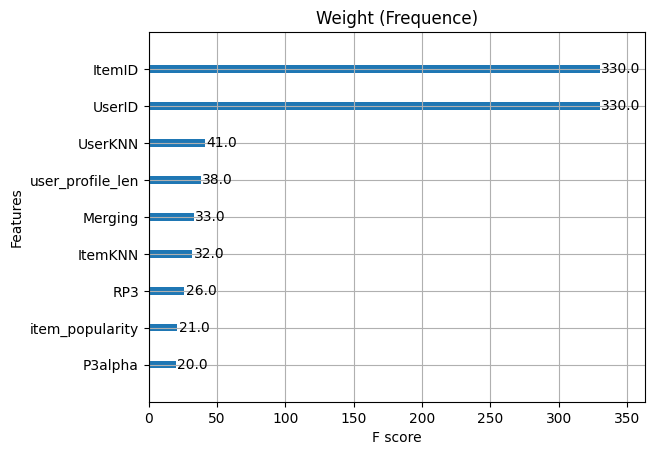

In [29]:
from xgboost import plot_importance

plot_importance(XGB_model, importance_type='weight', title='Weight (Frequence)')

In [30]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

hybrid_similarity = ItemKNNSimilarityHybridRecommender(URM_train_complete, recommender_item.W_sparse, recommender_rp3.W_sparse)
hybrid_similarity.fit(**params_merging)

weights = [params_lr_comb['w1'], params_lr_comb['w2'], params_lr_comb['w3']]
linear_combinator = LinearCombinationRecommender(URM_train_complete, [recommender_item, recommender_rp3, recommender_p3a], weights)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4593.10 column/sec. Elapsed time 4.87 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4492.70 column/sec. Elapsed time 2.90 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2886.22 column/sec. Elapsed time 7.74 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3232.87 column/sec. Elapsed time 6.91 sec
ItemKNNSimilarityHybridRecommender: URM Detected 627 ( 4.8%) use

In [31]:
cutoff = 20
n_users, n_items = URM_train.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations = linear_combinator.recommend(user_id, cutoff = cutoff)
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for user_id in tqdm.tqdm_notebook(range(n_users)):
    item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
    
    validation_dataframe.loc[user_id, 'UserKNN'] = recommender_user._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'RP3'] = recommender_rp3._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'P3alpha'] = recommender_p3a._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'Merging'] = hybrid_similarity._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]
    validation_dataframe.loc[user_id, 'ItemKNN'] = recommender_item._compute_item_score([user_id], items_to_compute = item_list)[0, item_list]

validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]
user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

/tmp/ipykernel_20/3700676400.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/3700676400.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,UserKNN,RP3,P3alpha,Merging,ItemKNN,item_popularity,user_profile_len
0,0,35,3.592918,0.553679,0.465694,0.592160,0.667676,464,28
1,0,100,3.220254,0.403084,0.345509,0.465530,0.588078,262,28
2,0,402,1.441025,0.246941,0.131656,0.306601,0.423680,86,28
3,0,505,1.604936,0.241477,0.133074,0.272686,0.333933,90,28
4,0,122,5.452755,0.214088,0.162935,0.239091,0.288159,133,28
...,...,...,...,...,...,...,...,...,...
260475,13023,7770,0.977660,0.243339,0.138749,0.290693,0.383622,11,46
260476,13023,291,2.837591,0.191506,0.076207,0.305748,0.529941,112,46
260477,13023,324,2.916834,0.224872,0.102530,0.293132,0.427087,135,46
260478,13023,8258,0.967202,0.200164,0.082813,0.283604,0.447348,10,46


In [32]:
validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

In [33]:
class TmpRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict(df_slice)
            recommendations.append(items[np.argsort(preds)[-cutoff:]].tolist())
            
        rec, scores = linear_combinator.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            
        if return_scores:
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [34]:
recommender = TmpRecommender(URM_train_complete, XGB_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 1.53 min. Users per second: 114


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.09167,0.159482,0.135034,0.032079,0.047668,0.162574,0.110404,0.109204,0.508512,0.226102,...,0.802826,0.408246,0.802826,0.065381,10.424341,0.998286,0.18865,0.803051,1.574261,0.304334


In [35]:
def objective_xgboost(trial):

    XGB_model = XGBRanker(
        objective='rank:pairwise',
        n_estimators = trial.suggest_int('n_estimators', 10, 1000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 0.1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 0.1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 15),
        max_leaves = trial.suggest_int('max_leaves', 8, 512),
        grow_policy = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
        verbosity = 2,
        booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear']),
        # tree_method = trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
        gamma = trial.suggest_float('gamma', 1e-6, 1, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-6, 0.1, log=True),
        subsample = trial.suggest_float('subsample ', 0.05, 0.9),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9),
        enable_categorical = True
    )
    
    XGB_model.fit(
        X_train,
        y_train,
        group=groups,
        verbose=True
    )
    
    recommender = TmpRecommender(URM_train_complete, XGB_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [36]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_xgboost.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [37]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='hyperparameters_tuning_xgboost', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=10)

[I 2023-11-28 23:35:07,681] A new study created in RDB with name: hyperparameters_tuning_xgboost
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:35:07] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.56 min. Users per second: 111


[I 2023-11-28 23:36:44,610] Trial 0 finished with value: 0.0299745152779296 and parameters: {'n_estimators': 68, 'learning_rate': 0.00010308230584754828, 'reg_alpha': 0.007338885058833215, 'reg_lambda': 0.044136424292205316, 'max_depth': 8, 'max_leaves': 487, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 0.059650846649655205, 'min_child_weight': 0.00044248965214992, 'subsample ': 0.7572033044832439, 'colsample_bytree': 0.7483590698937429}. Best is trial 0 with value: 0.0299745152779296.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:36:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.56 min. Users per second: 112


[I 2023-11-28 23:38:20,215] Trial 1 finished with value: 0.0301157306202257 and parameters: {'n_estimators': 49, 'learning_rate': 0.011690752263437352, 'reg_alpha': 0.005092025721022892, 'reg_lambda': 9.784897093017964e-05, 'max_depth': 9, 'max_leaves': 86, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 0.11209874810735719, 'min_child_weight': 0.042649238330187786, 'subsample ': 0.11396552031026913, 'colsample_bytree': 0.4980447835452604}. Best is trial 1 with value: 0.0301157306202257.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.50 min. Users per second: 116


[I 2023-11-28 23:39:55,098] Trial 2 finished with value: 0.03362110764989491 and parameters: {'n_estimators': 69, 'learning_rate': 0.016144404979120376, 'reg_alpha': 0.005951632463495529, 'reg_lambda': 8.232118859996242e-05, 'max_depth': 4, 'max_leaves': 357, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.510628127459628, 'min_child_weight': 4.796110946557189e-05, 'subsample ': 0.4704953047759354, 'colsample_bytree': 0.71749680051672}. Best is trial 2 with value: 0.03362110764989491.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.74 min. Users per second: 64


[I 2023-11-28 23:44:49,831] Trial 3 finished with value: 0.032517810841500634 and parameters: {'n_estimators': 772, 'learning_rate': 0.00020352040127056298, 'reg_alpha': 0.00024240582758873632, 'reg_lambda': 0.06090845046046959, 'max_depth': 13, 'max_leaves': 42, 'grow_policy': 'depthwise', 'booster': 'gbtree', 'gamma': 3.0152649392443477e-05, 'min_child_weight': 0.0003725315919667438, 'subsample ': 0.6929673173582098, 'colsample_bytree': 0.8999875008938555}. Best is trial 2 with value: 0.03362110764989491.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:44:50] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.49 min. Users per second: 117


[I 2023-11-28 23:46:32,772] Trial 4 finished with value: 0.031133127026633126 and parameters: {'n_estimators': 322, 'learning_rate': 0.00019401599855973513, 'reg_alpha': 1.1257543994538447e-05, 'reg_lambda': 0.03415559135838219, 'max_depth': 14, 'max_leaves': 465, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 4.774547886933444e-06, 'min_child_weight': 3.1081584672904306e-06, 'subsample ': 0.1975457027467047, 'colsample_bytree': 0.8369607036797476}. Best is trial 2 with value: 0.03362110764989491.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:46:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.48 min. Users per second: 118


[I 2023-11-28 23:48:05,347] Trial 5 finished with value: 0.03028428273885431 and parameters: {'n_estimators': 91, 'learning_rate': 0.01709646666525764, 'reg_alpha': 0.00356719068495765, 'reg_lambda': 0.0487023698030933, 'max_depth': 3, 'max_leaves': 288, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 1.992466448883002e-05, 'min_child_weight': 0.0002478645427568921, 'subsample ': 0.31299367601333333, 'colsample_bytree': 0.8860115169694868}. Best is trial 2 with value: 0.03362110764989491.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:48:05] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.44 min. Users per second: 121


[I 2023-11-28 23:49:36,312] Trial 6 finished with value: 0.0299777070353773 and parameters: {'n_estimators': 111, 'learning_rate': 0.00255803121515507, 'reg_alpha': 0.017948656930612872, 'reg_lambda': 0.019697708625523183, 'max_depth': 14, 'max_leaves': 135, 'grow_policy': 'depthwise', 'booster': 'gblinear', 'gamma': 2.604228016726318e-05, 'min_child_weight': 0.00460811980768057, 'subsample ': 0.4285488607643347, 'colsample_bytree': 0.2045788663819592}. Best is trial 2 with value: 0.03362110764989491.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.12 min. Users per second: 82


[I 2023-11-28 23:52:44,032] Trial 7 finished with value: 0.03195186025187937 and parameters: {'n_estimators': 488, 'learning_rate': 0.013054756595818503, 'reg_alpha': 0.03589634891986135, 'reg_lambda': 0.048366074008561404, 'max_depth': 10, 'max_leaves': 459, 'grow_policy': 'lossguide', 'booster': 'gbtree', 'gamma': 0.008791318871080707, 'min_child_weight': 0.0011279811891432118, 'subsample ': 0.07203527786538365, 'colsample_bytree': 0.421757071925594}. Best is trial 2 with value: 0.03362110764989491.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:52:44] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.50 min. Users per second: 116


[I 2023-11-28 23:54:32,794] Trial 8 finished with value: 0.030019002532152957 and parameters: {'n_estimators': 425, 'learning_rate': 0.001966489776750152, 'reg_alpha': 0.017506226558005367, 'reg_lambda': 0.00022089987740632448, 'max_depth': 8, 'max_leaves': 47, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 0.00016191805818317105, 'min_child_weight': 1.3964827263208098e-05, 'subsample ': 0.6782409892094082, 'colsample_bytree': 0.4620320704470188}. Best is trial 2 with value: 0.03362110764989491.
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [23:54:33] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "colsample_bytree", "gamma", "grow_policy", "max_depth", "max_leaves", "min_child_weight", "subsample" } are not used.

  warnings.warn(smsg, UserWarning)


EvaluatorHoldout: Processed 10456 (100.0%) in 1.51 min. Users per second: 116


[I 2023-11-28 23:56:22,518] Trial 9 finished with value: 0.030393235144095983 and parameters: {'n_estimators': 489, 'learning_rate': 0.03781035177574465, 'reg_alpha': 0.003979243846386188, 'reg_lambda': 0.003148266283255973, 'max_depth': 5, 'max_leaves': 24, 'grow_policy': 'lossguide', 'booster': 'gblinear', 'gamma': 0.04388830981813862, 'min_child_weight': 0.0011529966777114639, 'subsample ': 0.20135867265507734, 'colsample_bytree': 0.3472753586696083}. Best is trial 2 with value: 0.03362110764989491.


In [38]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [39]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [40]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [41]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_hybrid_xgboost.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_hybrid_xgboost.json', 
            'tuning_results/best_params_hybrid_xgboost.json', 
            'XGBoost tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/linear-combination/best_params_hybrid_xgboost.json', 
        '/kaggle/working/best_params_hybrid_xgboost.json'
    )

In [42]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_xgboost.db', 
        'Linear combination of Item KNN, RP3 and P3alpha tuning db updated results (from kaggle notebook)'
    )

In [43]:
# with open('/kaggle/working/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
#     params = json.load(params_file)
# params

In [44]:
# recommender_item = ItemKNNCFRecommender(URM_all)
# recommender_item.fit(**params_item_knn)

# recommender_rp3 = RP3betaRecommender(URM_all)
# recommender_rp3.fit(**params_rp3)

# recommender_p3a = P3alphaRecommender(URM_all)
# recommender_p3a.fit(**params_p3alpha)

# weights = [params['w1'], params['w2'], params['w3']]
# linear_combinator = LinearCombinationRecommender(URM_all, [recommender_item, recommender_rp3, recommender_p3a], weights)
# recommendations = linear_combinator.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
# recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

# submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
# display(submission_df.head())

# submission_df.to_csv('/kaggle/working/submission_linear_comb_knn_rp3_p3a.csv', index=False)